# Programming Lab 4 - Unsupervised Learning

***
##### CS 434 - Data Mining and Machine Learning
##### Oregon State University-Cascades
***

In [0]:
name = 'Taylor Mallory'

***
# Load packages 
***

Add the packages you need here (not below!)

In [3]:
import textwrap
from os import path
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
tqdm().pandas()
from matplotlib import pyplot as plt
assert name != '<replace with your name>'
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
# add more packages if needed...
from sklearn.metrics import silhouette_samples
from matplotlib import cm


***
# Data
***

This is a dataset of features derived from live recordings of high school English classrooms. We attempt to predict if a teacher's spoken utterance is a **Question** or **Not a Question**. 

> We investigate automatic detection of teacher questions from audio recordings collected in live classrooms with the goal of providing automated feedback to teachers. Using a dataset of audio recordings from 16 teachers across 127 class sessions, we automatically segment the audio into individual teacher utterances and code each as containing a question or not. 

Read more about this research
[here](https://dl.acm.org/doi/pdf/10.1145/3027385.3027417) or
[here](https://dl.acm.org/doi/pdf/10.1145/2930238.2930250).

### Load data

 Download and unzip the dataset.

In [0]:
# url of the data zip file
url = 'https://github.com/Soundbendor/cs434/raw/master/lab4.7z'
z_file = 'lab4.7z'

In [5]:
# download file and unzip
if (not path.exists(z_file)):
  !wget $url
  !7za e $z_file
else:
  print('data has already been downloaded')

--2020-05-24 15:32:20--  https://github.com/Soundbendor/cs434/raw/master/lab4.7z
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Soundbendor/cs434/master/lab4.7z [following]
--2020-05-24 15:32:20--  https://raw.githubusercontent.com/Soundbendor/cs434/master/lab4.7z
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24403447 (23M) [application/octet-stream]
Saving to: ‘lab4.7z’

lab4.7z             100%[===================>]  23.27M  31.1MB/s    in 0.7s    

2020-05-24 15:32:21 (31.1 MB/s) - ‘lab4.7z’ saved [24403447/24403447]


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zi

### Acoustic features

These features represent acoustic and spectral features derived directly from the audio signal of the utterance. 

In [6]:
# Acoustic features
df_acoustic = pd.read_csv('CETA-acoustic.csv', index_col=0)
df_acoustic

,pcm_RMSenergy_sma_max,pcm_RMSenergy_sma_min,pcm_RMSenergy_sma_range,pcm_RMSenergy_sma_maxPos,pcm_RMSenergy_sma_minPos,pcm_RMSenergy_sma_amean,pcm_RMSenergy_sma_linregc1,pcm_RMSenergy_sma_linregc2,pcm_RMSenergy_sma_linregerrQ,pcm_RMSenergy_sma_stddev,pcm_RMSenergy_sma_skewness,pcm_RMSenergy_sma_kurtosis,pcm_fftMag_mfcc_sma.1._max,pcm_fftMag_mfcc_sma.1._min,pcm_fftMag_mfcc_sma.1._range,pcm_fftMag_mfcc_sma.1._maxPos,pcm_fftMag_mfcc_sma.1._minPos,pcm_fftMag_mfcc_sma.1._amean,pcm_fftMag_mfcc_sma.1._linregc1,pcm_fftMag_mfcc_sma.1._linregc2,pcm_fftMag_mfcc_sma.1._linregerrQ,pcm_fftMag_mfcc_sma.1._stddev,pcm_fftMag_mfcc_sma.1._skewness,pcm_fftMag_mfcc_sma.1._kurtosis,pcm_fftMag_mfcc_sma.2._max,pcm_fftMag_mfcc_sma.2._min,pcm_fftMag_mfcc_sma.2._range,pcm_fftMag_mfcc_sma.2._maxPos,pcm_fftMag_mfcc_sma.2._minPos,pcm_fftMag_mfcc_sma.2._amean,pcm_fftMag_mfcc_sma.2._linregc1,pcm_fftMag_mfcc_sma.2._linregc2,pcm_fftMag_mfcc_sma.2._linregerrQ,pcm_fftMag_mfcc_sma.2._stddev,pcm_fftMag_mfcc_sma.2._skewness,pcm_fftMag_mfcc_sma.2._kurtosis,pcm_fftMag_mfcc_sma.3._max,pcm_fftMag_mfcc_sma.3._min,pcm_fftMag_mfcc_sma.3._range,pcm_fftMag_mfcc_sma.3._maxPos,...,pcm_fftMag_mfcc_sma_de.12._linregerrQ,pcm_fftMag_mfcc_sma_de.12._stddev,pcm_fftMag_mfcc_sma_de.12._skewness,pcm_fftMag_mfcc_sma_de.12._kurtosis,pcm_zcr_sma_de_max,pcm_zcr_sma_de_min,pcm_zcr_sma_de_range,pcm_zcr_sma_de_maxPos,pcm_zcr_sma_de_minPos,pcm_zcr_sma_de_amean,pcm_zcr_sma_de_linregc1,pcm_zcr_sma_de_linregc2,pcm_zcr_sma_de_linregerrQ,pcm_zcr_sma_de_stddev,pcm_zcr_sma_de_skewness,pcm_zcr_sma_de_kurtosis,voiceProb_sma_de_max,voiceProb_sma_de_min,voiceProb_sma_de_range,voiceProb_sma_de_maxPos,voiceProb_sma_de_minPos,voiceProb_sma_de_amean,voiceProb_sma_de_linregc1,voiceProb_sma_de_linregc2,voiceProb_sma_de_linregerrQ,voiceProb_sma_de_stddev,voiceProb_sma_de_skewness,voiceProb_sma_de_kurtosis,F0_sma_de_max,F0_sma_de_min,F0_sma_de_range,F0_sma_de_maxPos,F0_sma_de_minPos,F0_sma_de_amean,F0_sma_de_linregc1,F0_sma_de_linregc2,F0_sma_de_linregerrQ,F0_sma_de_stddev,F0_sma_de_skewness,F0_sma_de_kurtosis
ObsID_uttid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
sch01_tch01_03_19_18_period03_1,0.087673,0.000111,0.087562,12,62,0.016559,-7.500000e-05,0.022258,4.900740e-04,0.022384,1.663657,5.037719,1.354656,-21.23061,22.58527,147,3,-7.859150,0.014733,-8.978846,22.34667,4.771800,-0.353344,2.314024,9.906281,-11.87938,21.78566,78,11,-0.448185,0.008687,-1.108377,36.03586,6.015235,-0.196317,1.862175,21.15214,-13.56600,34.71814,82,...,1.976774,1.410995,-0.739355,5.817732,0.067083,-0.046083,0.113167,2,6,0.000055,-2.790000e-05,0.002177,0.000160,0.012728,1.417733,12.093970,0.106449,-0.072128,0.178578,6,91,0.000368,-8.130000e-05,0.006544,0.000869,0.029698,0.673016,4.083345,45.02766,-46.80123,91.82889,11,19,1.240000e-09,-0.009379,0.712786,174.73060,13.225060,-0.073110,7.106480
sch01_tch01_03_19_18_period03_101,0.089464,0.000094,0.089370,200,106,0.009443,6.680000e-05,0.002030,2.840640e-04,0.017394,2.805388,11.244170,4.792966,-28.74917,33.54213,53,171,-10.802100,0.010110,-11.924270,45.03678,6.742426,-0.076793,3.004732,8.236449,-12.77728,21.01373,32,49,-1.412493,-0.009197,-0.391609,20.12749,4.525265,-0.320538,2.718962,19.98756,-14.15172,34.13927,36,...,1.250721,1.118659,-0.064321,2.796811,0.149000,-0.150917,0.299917,169,175,0.000083,-8.140000e-06,0.000987,0.000732,0.027060,0.190691,19.135920,0.081033,-0.050023,0.131057,7,21,0.000967,-1.310000e-05,0.002417,0.000499,0.022359,0.636079,4.281152,29.98096,-29.98096,59.96191,189,192,0.000000e+00,-0.000324,0.036012,16.57059,4.070752,0.002069,41.089630
sch01_tch01_03_19_18_period03_102,0.172714,0.000115,0.172599,69,181,0.042824,-1.158980e-04,0.061600,1.900017e-03,0.044925,0.968963,3.159101,4.541859,-33.61803,38.15989,273,13,-12.244440,0.010436,-13.935030,36.69866,6.136549,-1.061252,5.153325,13.915230,-14.15155,28.06678,114,25,-2.689022,0.002170,-3.040607,44.91985,6.705319,0.561020,2.582015,13.13760,-16.69275,29.83035,281,...,1.813422,1.348060,-0.

### Language features

The audio files were transcribed by IBM's Watson. These features are derived from the ASR transcription following linguistic analysis.

In [7]:
# Language features
df_language = pd.read_csv('CETA-language.csv', index_col=0)
df_language = df_language.fillna(0)  # missing values are False (0)
df_language

,X.BE,X.DOHAVE,X.HOW,X.MODAL,X.SHOULD,X.WH,X.WHAT,X.WHY,ADJADV_TAG,CAUSAL_ANTECEDENTKEY,CAUSAL_CONSEQUENTKEY,COMPARISONKEY,DEFINITIONKEY,DISJUNCTIONKEY,DT_TAG,ENABLEMENTKEY,EXAMPLEKEY,FEATURE_SPECIFICATIONKEY,GOAL_ORIENTATIONKEY,HAPPEN,INTERPRETATIONKEY,ImprobUptakeKey,JJ_TAG,JUDGMENTALKEY,METACOG,METACOM,NEG,NO,NOUN_TAG,PREP_TAG,PROCEDURALKEY,PRONOUN_TAG,PROPERNOUN_TAG,ProbUptakeKey,QUANTIFICATIONKEY,VB_TAG,YES,nsource,nsourceb,nsorq,...,CAUSAL_ANTECEDENTKEY_a,GOAL_ORIENTATIONKEY.first_a,GOAL_ORIENTATIONKEY.later_a,GOAL_ORIENTATIONKEY_a,JUDGMENTALKEY.first_a,JUDGMENTALKEY.later_a,JUDGMENTALKEY_a,INTERPRETATIONKEY.first_a,INTERPRETATIONKEY.later_a,INTERPRETATIONKEY_a,ProbUptakeKey.first_a,ProbUptakeKey.later_a,ProbUptakeKey_a,ImprobUptakeKey.first_a,ImprobUptakeKey.later_a,ImprobUptakeKey_a,attribution_a,background_a,cause_a,comparison_a,condition_a,contrast_a,elaboration_a,enablement_a,evaluation_a,explanation_a,joint_a,manner.means_a,topic.comment_a,summary_a,temporal_a,topic.change_a,textual.organization_a,same.unit_a,root_a,nucleus_a,satellite_a,wordCount_a,person.first_a,person.last_a
ObsID_uttid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
sch01_tch01_03_19_18_period03_1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,5,1,2.0,...,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,5,0,0,0,0,0,1,0,0,0,0,0,0,7,1,6,0,0
sch01_tch01_03_19_18_period03_101,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,5,1,2.0,...,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,4,0,0,0,0,1,5,0,0,0,0,0,1,0,0,0,1,0,0,6,7,5,0,0
sch01_tch01_03_19_18_period03_102,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,1,1,0,1,0,5,1,3.0,...,0,0,0,0,0,0,0,0,0,0,0,3,3,0,2,2,4,0,0,0,0,1,6,0,0,0,0,0,1,0,0,0,1,0,0,5,9,11,0,0
sch01_tch01_03_19_18_period03_103,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,1,0,5,1,3.0,...,0,0,0,0,0,0,0,0,0,0,0,2,2,0,0,0,4,0,0,0,0,1,6,0,0,0,0,0,1,0,0,0,1,0,0,9,5,16,0,0
sch01_tch01_03_19_18_period03_104,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,1,1,0,1,0,0,0,1,1,0,1,1,1,0,1,1,5,1,3.0,...,0,0,0,0,0,0,0,0,0,0,0,4,4,0,2,2,5,0,0,0,0,1,9,0,0,0,0,0,1,0,0,0,1,0,0,10,8,45,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sch03_tch04_06_06_18_period06_9,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,5,1,2.0,...,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,1,0,0,0,0,0,0,8,1,7,0,0
sch03_tch04_06_06_18_period06_90,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,1,0,0,0,1,1,0,1,0,1,1,1,1,0,1,1,1,0,1,1,5,1,3.0,...,0,0,0,0,0,0,0,0,0,0,0,2,2,0,2,2,1,0,0,0,0,0,11,0,1,0,0,0,1,0,0,0,0,0,0,4,11,53,0,0
sch03_tch04_06_06_18_period06_91,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,1,0,5,1,3.0,...,0,0,0,0,0,0,0,0,1,1,0,1,1,0,0,0,1,0,0,0,0,0,8,0,1,0,0,0,1,0,0,0,0,0,0,4,8,10,0,0


### Context features

These features represent the timing between utterances and other contextual features. 

In [8]:
# Timing features
df_context = pd.read_csv('CETA-timing.csv', index_col=0)
df_context

,lenNextUtt,lenPrevUtt,lenUtt,numWordsInNextUtt,numWordsInPrevUtt,numWordsInUtt,pauseAfter,pauseBefore,position,speechRate,verbosity
ObsID_uttid,,,,,,,,,,,
sch01_tch01_03_19_18_period03_1,5.61,0.00,1.57,25,0,4,540.18,0.00,0.314944,3.184713,5
sch01_tch01_03_19_18_period03_101,3.29,5.14,2.27,9,21,3,-596.46,-456.82,0.632271,1.762115,4
sch01_tch01_03_19_18_period03_102,3.28,2.27,3.29,14,3,9,912.64,-596.46,0.473192,2.735562,9
sch01_tch01_03_19_18_period03_103,13.58,3.29,3.28,43,9,14,195.90,912.64,0.718408,4.573171,15
sch01_tch01_03_19_18_period03_104,89.65,3.28,13.58,267,14,43,-689.84,195.90,0.771733,3.092784,42
...,...,...,...,...,...,...,...,...,...,...,...
sch03_tch04_06_06_18_period06_9,0.31,12.77,1.16,1,37,5,101.62,585.98,0.610590,5.172414,6
sch03_tch04_06_06_18_period06_90,2.40,4.94,16.90,8,19,51,180.89,45.27,0.110258,2.899408,49
sch03_tch04_06_06_18_period06_91,1.22,16.90,2.40,2,51,8,478.66,180.89,0.297868,3.750000,9


### Metadata (not for learning)

These features contain information about the utterance.  They are not to be used as features in learning. 

We use the `TeacherId` in the (provided) cross-validation.

The column `IsQuestion` is the outcome we predict in our experiment. 
 * `1` indicates a 'Question'
 * `0` indicates 'Not a Question'

> Although not used in this Lab, `IsInstructionalUtterance` and `IsDisciplinaryUtterance` are other possible outcomes. The first determines if the utterances is instructional (by metrics of educational researchers) and the second determines if the utterance contains termininology from the discipline (e.g., *theme*, *plot*, *poem*, etc.).  These problems are harder than `IsQuestion`. 

In [9]:
# Metadata
df_meta = pd.read_csv('CETA-meta.csv', index_col=0).fillna('Statement')
df_meta['IsQuestion'] = df_meta['IsQuestion'].map({'Question':1,'Statement':0,'Fragment':0,'-':0})
df_meta

,ObsID,TeacherID,TranscribedUtterance,IsQuestion,IsInstructionalUtterance,IsDisciplinaryUtterance
ObsID_uttid,,,,,,
sch01_tch01_03_19_18_period03_1,sch01_tch01_03_19_18_period03,sch01_tch01,oh you mean the,1,1,1
sch01_tch01_03_19_18_period03_101,sch01_tch01_03_19_18_period03,sch01_tch01,thank you somebody,1,1,0
sch01_tch01_03_19_18_period03_102,sch01_tch01_03_19_18_period03,sch01_tch01,so I'll need some some help reading it,0,1,1
sch01_tch01_03_19_18_period03_103,sch01_tch01_03_19_18_period03,sch01_tch01,you will have died from walking across the str...,0,0,0
sch01_tch01_03_19_18_period03_104,sch01_tch01_03_19_18_period03,sch01_tch01,get a very good soil goes into like that aware...,0,1,1
...,...,...,...,...,...,...
sch03_tch04_06_06_18_period06_9,sch03_tch04_06_06_18_period06,sch03_tch04,what else do you see,1,1,1
sch03_tch04_06_06_18_period06_90,sch03_tch04_06_06_18_period06,sch03_tch04,okay but look at the palm again do you see joy...,0,1,1
sch03_tch04_06_06_18_period06_91,sch03_tch04_06_06_18_period06,sch03_tch04,maybe that would solve the problem for now,0,1,1


### Merge features

Merge the three features sets together as `df_feats`.

In [10]:
df_feats = pd.merge(df_context, df_acoustic, on='ObsID_uttid')
df_feats = pd.merge(df_feats, df_language,  on='ObsID_uttid')
df_feats

,lenNextUtt,lenPrevUtt,lenUtt,numWordsInNextUtt,numWordsInPrevUtt,numWordsInUtt,pauseAfter,pauseBefore,position,speechRate,verbosity,pcm_RMSenergy_sma_max,pcm_RMSenergy_sma_min,pcm_RMSenergy_sma_range,pcm_RMSenergy_sma_maxPos,pcm_RMSenergy_sma_minPos,pcm_RMSenergy_sma_amean,pcm_RMSenergy_sma_linregc1,pcm_RMSenergy_sma_linregc2,pcm_RMSenergy_sma_linregerrQ,pcm_RMSenergy_sma_stddev,pcm_RMSenergy_sma_skewness,pcm_RMSenergy_sma_kurtosis,pcm_fftMag_mfcc_sma.1._max,pcm_fftMag_mfcc_sma.1._min,pcm_fftMag_mfcc_sma.1._range,pcm_fftMag_mfcc_sma.1._maxPos,pcm_fftMag_mfcc_sma.1._minPos,pcm_fftMag_mfcc_sma.1._amean,pcm_fftMag_mfcc_sma.1._linregc1,pcm_fftMag_mfcc_sma.1._linregc2,pcm_fftMag_mfcc_sma.1._linregerrQ,pcm_fftMag_mfcc_sma.1._stddev,pcm_fftMag_mfcc_sma.1._skewness,pcm_fftMag_mfcc_sma.1._kurtosis,pcm_fftMag_mfcc_sma.2._max,pcm_fftMag_mfcc_sma.2._min,pcm_fftMag_mfcc_sma.2._range,pcm_fftMag_mfcc_sma.2._maxPos,pcm_fftMag_mfcc_sma.2._minPos,...,CAUSAL_ANTECEDENTKEY_a,GOAL_ORIENTATIONKEY.first_a,GOAL_ORIENTATIONKEY.later_a,GOAL_ORIENTATIONKEY_a,JUDGMENTALKEY.first_a,JUDGMENTALKEY.later_a,JUDGMENTALKEY_a,INTERPRETATIONKEY.first_a,INTERPRETATIONKEY.later_a,INTERPRETATIONKEY_a,ProbUptakeKey.first_a,ProbUptakeKey.later_a,ProbUptakeKey_a,ImprobUptakeKey.first_a,ImprobUptakeKey.later_a,ImprobUptakeKey_a,attribution_a,background_a,cause_a,comparison_a,condition_a,contrast_a,elaboration_a,enablement_a,evaluation_a,explanation_a,joint_a,manner.means_a,topic.comment_a,summary_a,temporal_a,topic.change_a,textual.organization_a,same.unit_a,root_a,nucleus_a,satellite_a,wordCount_a,person.first_a,person.last_a
ObsID_uttid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
sch01_tch01_03_19_18_period03_1,5.61,0.00,1.57,25,0,4,540.18,0.00,0.314944,3.184713,5,0.087673,0.000111,0.087562,12,62,0.016559,-7.500000e-05,0.022258,4.900740e-04,0.022384,1.663657,5.037719,1.354656,-21.23061,22.58527,147,3,-7.859150,0.014733,-8.978846,22.34667,4.771800,-0.353344,2.314024,9.906281,-11.87938,21.78566,78,11,...,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,5,0,0,0,0,0,1,0,0,0,0,0,0,7,1,6,0,0
sch01_tch01_03_19_18_period03_101,3.29,5.14,2.27,9,21,3,-596.46,-456.82,0.632271,1.762115,4,0.089464,0.000094,0.089370,200,106,0.009443,6.680000e-05,0.002030,2.840640e-04,0.017394,2.805388,11.244170,4.792966,-28.74917,33.54213,53,171,-10.802100,0.010110,-11.924270,45.03678,6.742426,-0.076793,3.004732,8.236449,-12.77728,21.01373,32,49,...,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,4,0,0,0,0,1,5,0,0,0,0,0,1,0,0,0,1,0,0,6,7,5,0,0
sch01_tch01_03_19_18_period03_102,3.28,2.27,3.29,14,3,9,912.64,-596.46,0.473192,2.735562,9,0.172714,0.000115,0.172599,69,181,0.042824,-1.158980e-04,0.061600,1.900017e-03,0.044925,0.968963,3.159101,4.541859,-33.61803,38.15989,273,13,-12.244440,0.010436,-13.935030,36.69866,6.136549,-1.061252,5.153325,13.915230,-14.15155,28.06678,114,25,...,0,0,0,0,0,0,0,0,0,0,0,3,3,0,2,2,4,0,0,0,0,1,6,0,0,0,0,0,1,0,0,0,1,0,0,5,9,11,0,0
sch01_tch01_03_19_18_period03_103,13.58,3.29,3.28,43,9,14,195.90,912.64,0.718408,4.573171,15,0.001775,0.000132,0.001642,315,161,0.000486,1.050000e-07,0.000469,1.220000e-07,0.000350,1.593941,5.212562,-9.051345,-24.07594,15.02459,117,189,-13.779130,-0.003243,-13.255370,10.32773,3.227961,-1.268455,4.472436,10.311480,-21.32470,31.63618,248,69,...,0,0,0,0,0,0,0,0,0,0,0,2,2,0,0,0,4,0,0,0,0,1,6,0,0,0,0,0,1,0,0,0,1,0,0,9,5,16,0,0
sch01_tch01_03_19_18_period03_104,89.65,3.28,13.58,267,14,43,-689.84,195.90,0.771733,3.092784,42,0.084574,0.000108,0.084467,816,1,0.018035,6.410000e-06,0.013700,3.888910e-04,0.019879,1.163388,3.382645,7.474018,-32.40612,39.88013,941,633,-9.685631,0.000335,-9.912446,54.33177,7.372173,-0.714867,3.526981,18.570830,-16.80267,35.37350,509,993,...,0,0,0,0,0,0,0,0,0,0,0,4,4,0,2,2,5,0,0,0,0,1,9,0,0,0,0,0,1,0,0,0,1,0,0,10,8,45,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [0]:
assert df_feats.shape[0]==16977 and df_feats.shape[1]==714

### Random utterance generator

This prints a random utterance transcription. Repeat to explore the data.

In [12]:
# print a random utterance
print(textwrap.fill(df_meta['TranscribedUtterance'].sample(1)[0], 100))

we wait if you see you said that too easily if you ask the robot robot to you're asking and which
stores the other robot so this guy which store would he say


***
# Provided functions
***

This function runs a supervised classification experiment.

> Here we perform *Leave one-teacher-out cross-validation*.
>
> If we randomly split the examples in train and test, then audio utterances from a single speaker (teacher) will be in both sets. We want to ensure the model is not accidentally learning unique speech characteristics of specific individuals, but rather the qualities representative of a Question. In other words, we want to be able to generalize to new speakers.  Therefore we train on 15 teachers and test on 1, and iteratively repeat this process with cross-validation.

In [0]:
def experiment(pipe_clf, X, y):
  # empty df for returning results
  df_result = pd.DataFrame(columns=['Session', 'Teacher', 'True', 'Pred'])

  # leave one teacher out cross-validation
  teachers = df_meta['TeacherID'].unique()
  for teacher in tqdm(teachers):
    # test examples come from one teacher; other teachers are training examples
    test_index = df_meta.index[df_meta['TeacherID'] == teacher].tolist()
    train_index = df_meta.index[df_meta['TeacherID'] != teacher].tolist()
    # session is one class period
    test_session = df_meta['TeacherID'].loc[test_index]

    # split train and test
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]

    # train and test1
    pipe_clf.fit(X_train, y_train)
    pred=pipe_clf.predict(X_test)   
    
    i=0
    # add predictions to df_results
    for session in test_session:
      df_result=df_result.append({'Session' : session, 'Teacher' : teacher, 'True': y_test[i], 'Pred': pred[i]}, ignore_index=True)
      i=i+1

  df_result['True'] = df_result['True'].astype(int)
  df_result['Pred'] = df_result['Pred'].astype(int)

  # return results
  return df_result

This function graphs a confusion matrix.

In [0]:
# graph a confusion matrix
def graph_confmat(y_true, y_pred):
  confmat = confusion_matrix(y_true=y_true, y_pred=y_pred)
  fig, ax = plt.subplots(figsize=(3, 3))
  ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
  for i in range(confmat.shape[0]):
      for j in range(confmat.shape[1]):
          ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
  plt.xlabel('Predicted label')
  plt.ylabel('True label')
  plt.tight_layout()
  plt.show()

***
# Lab Objective
***

## Baseline experiment (provided)

In this experiment we predict whether a spoken utterance contains a question or not. 


              precision    recall  f1-score   support

           0       0.87      0.98      0.92     11595
           1       0.94      0.69      0.80      5382

    accuracy                           0.89     16977
   macro avg       0.91      0.83      0.86     16977
weighted avg       0.89      0.89      0.88     16977



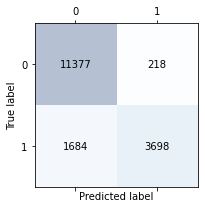

In [15]:
pipe_baseline = make_pipeline(StandardScaler(), PCA(random_state=1), RandomForestClassifier(n_estimators=10, random_state=1))
df_result = experiment(pipe_baseline, df_feats, df_meta['IsQuestion'])
print(classification_report(df_result['True'].values, df_result['Pred'].values))
graph_confmat(df_result['True'], df_result['Pred'])

We care most about the correctly classifying Questions (the lower-right quadrant of the confusion matrix). We didn't do so well. We want to improve this classification.

## Goal

You will run this supervised learning experiment again at the end of this Lab (provided).  Your task is to use *unsupervised learning* to improve our (supervised) classification result.

* **Task 1**: run Principle Component Analysis to reduce dimensionality.

* **Task 2**: run KMeans on each data subset and use the clusters as features in our classification task. 

***
# Task 1: Principle Component Analysis
***

**Objective**: determine the number of principle components to use in the final experiment.

1. Extract features from `df_feats`
1. Standardize the features before running PCA
1. Run PCA with `20` components and `random_state=1`
1. Graph `'Principal components'` vs `'Explained variance ratio'`
1. Choose the number of components that each individually explain `>0.01` of the variance.
  * update variable `pca_n_components`
  * we use this value in the later experiment


> Note: You should not directly change the data in `df_feats` during this task. 
>
> Here we determine the `pca_n_components` so we can run PCA later in the experiment.

## Student workspace

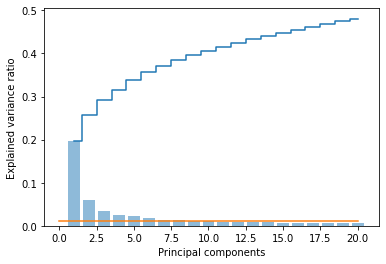

In [26]:
# add code and text blocks as needed
df_feats_copy = df_feats.copy().values
sc = StandardScaler()
new = sc.fit_transform(df_feats_copy)
pca = PCA(n_components=20, random_state=1)
out = pca.fit(new)
comp = out.components_
evr = out.explained_variance_ratio_

plt.bar(range(1, len(evr) + 1), evr, alpha=0.5, align='center')
plt.step(range(1, len(evr) + 1), np.cumsum(evr), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
xs = np.linspace(0,20,9)
line = np.array([.01 for i in range(len(xs))])
plt.plot(xs, line)
plt.show()

## Task Outcome

Update the value of `pca_n_components` to be the integer value you chose based on your above experiments. 

In [0]:
# update the RHS to be the value you chose
pca_n_components = 8                   # <== CHANGE VALUE!
# this value will be used in the final experiment

***
# Task 2: K-Means
***

**Objective**: run KMeans algorithm to find cluster assignments for each example.

For each feature subset {`df_acoustic`, `df_language`, `df_context`}:
  1. Use the elbow method (graph) to determine `n_clusters`
  1. Run `KMeans` using your value of `n_clusters`
    * use `random_state=1`
    * choose the other parameters to taste
  1. Save the cluster assignments
  1. Examine your cluster assignments
    * "goodness" (e.g., silhouette plots, cluster graphs)
    * examples per cluster (counts/distribution)

> You find and choose a different `n_clusters` value for each of the three data subsets.



## Student workspace

df_acoustic


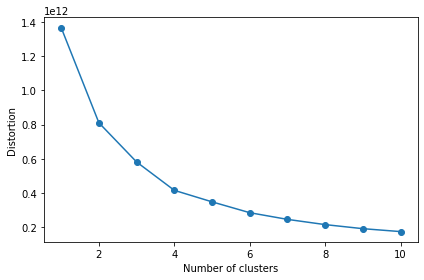

df_language


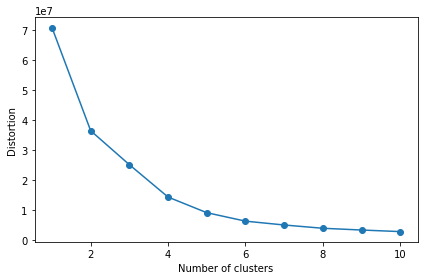

df_context


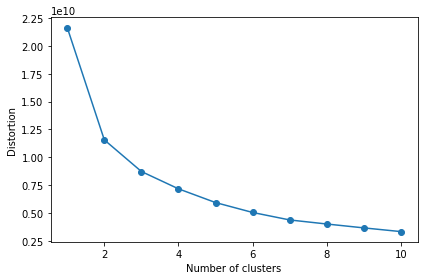

In [46]:
dfs = [df_acoustic, df_language, df_context]
df_names = ['df_acoustic', 'df_language', 'df_context']
for k, j in enumerate(dfs):
  X = j.copy().values
  pca = PCA(n_components=7, random_state=1)
  X = pca.fit_transform(X)

  distortions = []
  for i in range(1, 11):
      km = KMeans(n_clusters=i, 
                  init='k-means++', 
                  n_init=20, 
                  max_iter=500, 
                  random_state=1)
      km.fit(X)
      distortions.append(km.inertia_)
  plt.plot(range(1, 11), distortions, marker='o')
  plt.xlabel('Number of clusters')
  plt.ylabel('Distortion')
  plt.tight_layout()
  print(df_names[k])
  plt.show()

df_acoustic


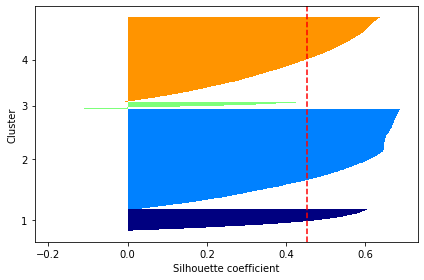

df_language


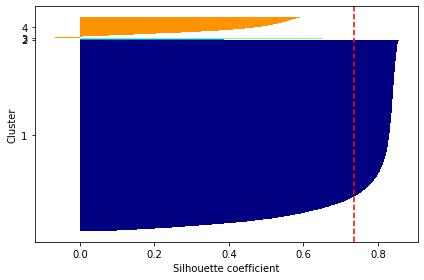

df_context


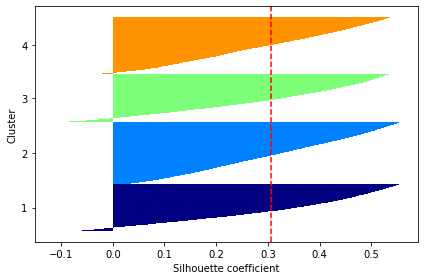

In [60]:
# add code and text blocks as needed
dfs = [df_acoustic, df_language, df_context]
df_names = ['df_acoustic', 'df_language', 'df_context']
for k, j in enumerate(dfs):
  X = j.copy().values
  pca = PCA(n_components=pca_n_components, random_state=1)
  X = pca.fit_transform(X)

  elbow = 4
  km = KMeans(n_clusters=elbow, 
                  init='k-means++', 
                  n_init=20, 
                  max_iter=500, 
                  random_state=1)
  km.fit(X)

  y_km = km.fit_predict(X)
  if(df_names[k] == 'df_acoustic'):
    y_km_aco = km.fit_predict(X)
  elif(df_names[k] == 'df_language'):
    y_km_lan = km.fit_predict(X)
  else:
    y_km_con = km.fit_predict(X)
  cluster_labels = np.unique(y_km)

  n_clusters = cluster_labels.shape[0]
  silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
  y_ax_lower, y_ax_upper = 0, 0
  yticks = []
  for i, c in enumerate(cluster_labels):
      c_silhouette_vals = silhouette_vals[y_km == c]
      c_silhouette_vals.sort()
      y_ax_upper += len(c_silhouette_vals)
      color = cm.jet(float(i) / n_clusters)
      plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
               edgecolor='none', color=color)

      yticks.append((y_ax_lower + y_ax_upper) / 2.)
      y_ax_lower += len(c_silhouette_vals)

  silhouette_avg = np.mean(silhouette_vals)
  plt.axvline(silhouette_avg, color="red", linestyle="--") 

  plt.yticks(yticks, cluster_labels + 1)
  plt.ylabel('Cluster')
  plt.xlabel('Silhouette coefficient')

  plt.tight_layout()
  print(df_names[k])
  plt.show()

## Task Outcome
To conclude this task, we save the cluster assignments as features to use in our final experiment below (provided).

> This assumes you named your cluster assignments as `y_km_aco`, `y_km_lan`, `y_km_con`, respectively.

In [0]:
# copy the features and add clusters
df_feats_clusters = df_feats.copy()            # copy features
df_feats_clusters['cluster_aco'] = y_km_aco    # acoustic clusters
df_feats_clusters['cluster_lan'] = y_km_lan    # language clusters
df_feats_clusters['cluster_con'] = y_km_con    # context  clusters

***
# Classification experiment
***

This repeats the Baseline experiment, with the addition of:
* PCA using `pca_n_components` you defined in Task 1.
* three new features (clusters) defined in Task 2.

In [0]:
# Task 1 updated? check
assert pca_n_components != df_feats.shape[1]
# Task 2 updated? check
assert df_feats_clusters.shape[1] == df_feats.shape[1] + 3 # clusters

This will take a few minutes. 


              precision    recall  f1-score   support

           0       0.97      0.98      0.97     11595
           1       0.95      0.93      0.94      5382

    accuracy                           0.96     16977
   macro avg       0.96      0.96      0.96     16977
weighted avg       0.96      0.96      0.96     16977



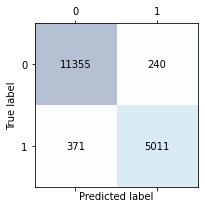

In [63]:
pipe_final = make_pipeline(StandardScaler(), PCA(pca_n_components, random_state=1), RandomForestClassifier(n_estimators=10, random_state=1))
df_result = experiment(pipe_final, df_feats_clusters, df_meta['IsQuestion'])
print(classification_report(df_result['True'].values, df_result['Pred'].values))
graph_confmat(df_result['True'], df_result['Pred'])

> If successful, the number of correctly classified Questions should be greater than the Baseline Experiment ($> 3698$).
>
> How much have you improved? **Can you do even better?**

***
# Report
***

Answer each question below in a few paragraphs. You should call functions you defined earlier to display graphs/charts in place to display your results and better support your discussion.

## Task 1: PCA

### Question

Describe your PCA experiment and justify your choice in the number of components.


### Answer

For this experiment, I standardized the features and then performed principle component analysis on them. After plotting explained variance/components, it appeared that there was less than .01 variance after 8 components. This seemed like the point of diminishing returns, so I chose the value 8 to use for my number of components moving forward.

## Task 2: KMeans

### Question

Describe your (three) KMeans experiments, justify your choice in the number of clusters chosen, and discuss the distribution of examples by cluster.

### Answer

For this experiment, I performed PCA on all three datasets, performed K Means for 1 to 11 clusters, and then used the "elbow" to decide the number of clusters moving forward. I then performed PCA again, performed K Means again using the "elbow" value (4) as the number of clusters, and then performed silhouette analysis. To be completely honest, I don't know what to think of my results. I tweaked "elbow" values and number of PCA components, and while all my predictions were higher than the base prediction of 3698, the results of my silhouette analysis was rather confusing. I used nearly every permutation of parameter values I could come up with and got wildly different outcomes. I would get a lower silhouette coefficient but more misclassifications. I would raise the raise the silhouette coefficient, get more misclassifications, and then have a less even spread of clusters. In the end, I decided to go with what the initial PCA and "elbow method" suggested, and used n = 8 for PCA components and n = 4 for number of K Means clusters.


## Conclusion

### Question

Describe the outcome of the final classification experiment and explain the reasons for any improvements you gained.

### Answer

For the final experiment, we performed PCA (with n components from the previous experiment) with a Random Forest Classifier, using the clusters from the previous experiment. Our inital classification, with just a Random Forest, resulted in 3698 correct classifications. Our final experiment resulted in 5011 correct classifications. I'm not entirely sure why this method produced better results, but from some further reading, I believe it is due to produced proximity matrix helps by optimizing the number of branches used in our Random Forest.

# Future Work



On your own (for fun/interest), you can use this process to classify the harder predictors of `IsInstructionalUtterance` and/or `IsDisciplinaryUtterance`.